# CT Preprocessing Quality Checks

This notebook documents post-preprocessing validation for the Pancreatic CT dataset.

**Goals:**
- Verify processed CT slice count and patient distribution.
- Ensure all file paths are valid and accessible.
- Check for image format consistency.
- Summarize slices per patient statistics.

In [1]:
import os
# Change to project root
os.chdir(r"C:\Users\Leander Antony A\Documents\Projects\Multimodal_Cancer_Detection")

In [2]:
from pathlib import Path
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

IDX_FULL  = Path("data/processed/ct_index.csv")
IDX_CLEAN = Path("data/processed/ct_index_clean.csv")
DROP_LOG  = Path("data/processed/dropped_slices_log.csv")
PAT_SUM   = Path("data/processed/ct_patient_summary.csv")
FIG_DIR   = Path("figures")
FIG_DIR.mkdir(exist_ok=True, parents=True)

print("Exists:",
      IDX_FULL.exists(), IDX_CLEAN.exists(),
      DROP_LOG.exists(), PAT_SUM.exists(), FIG_DIR.exists())

Exists: True True True True True


Dataset size & label distribution

In [3]:
idx_full  = pd.read_csv(IDX_FULL)
idx_clean = pd.read_csv(IDX_CLEAN)
print("Full slices:", len(idx_full))
print("Clean slices:", len(idx_clean))
print("Labels (clean):\n", idx_clean["label"].value_counts())
print("Patients (clean):\n", idx_clean.groupby("label")["patient_id"].nunique())

Full slices: 24627
Clean slices: 23319
Labels (clean):
 control    17749
cancer      5570
Name: label, dtype: int64
Patients (clean):
 label
cancer     40
control    80
Name: patient_id, dtype: int64


In [4]:
if DROP_LOG.exists():
    dropped = pd.read_csv(DROP_LOG)
    print("Dropped slices:", len(dropped))
    print(dropped["drop_reason"].value_counts())
    # peek a few
    dropped.head()
else:
    print("No drop log found (nothing dropped).")

Dropped slices: 1308
tiny_file    1308
Name: drop_reason, dtype: int64


In [5]:
shapes = set()
bad_open = []
for p in idx_clean['path']:
    try:
        with Image.open(p) as im:
            shapes.add((im.mode, im.size))
    except Exception as e:
        bad_open.append((p, str(e)))

print("Unique (mode, size) combos (clean):", shapes)
print("Failed to open (clean):", len(bad_open))
bad_open[:5]

Unique (mode, size) combos (clean): {('L', (224, 224))}
Failed to open (clean): 0


[]

In [7]:
per_patient = (
    idx_clean.groupby(['label','patient_id'])
             .size().rename('n_slices').reset_index()
)
per_patient.groupby('label')['n_slices'].describe()



,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
cancer,40.0,139.2500,52.473070,70.0,95.50,128.0,161.75,268.0
control,80.0,221.8625,34.676714,181.0,203.75,216.0,230.25,466.0


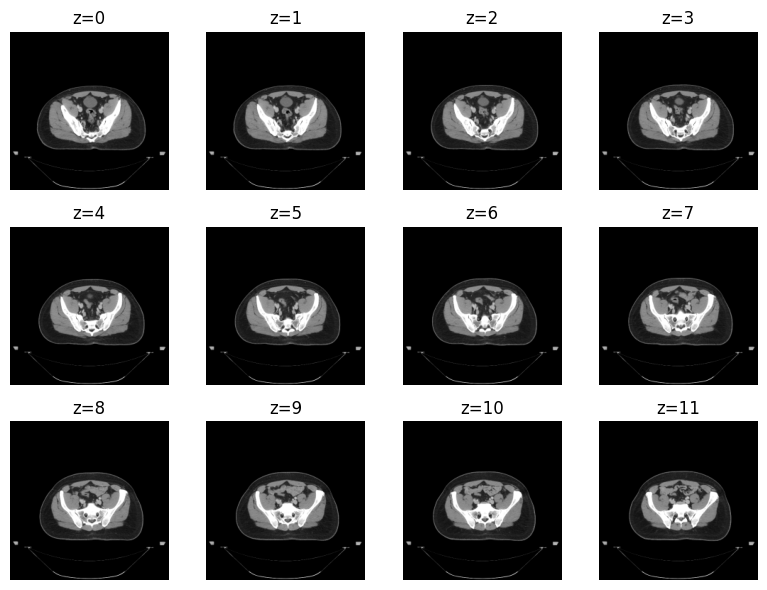

Saved figures\example_cancer_grid.png


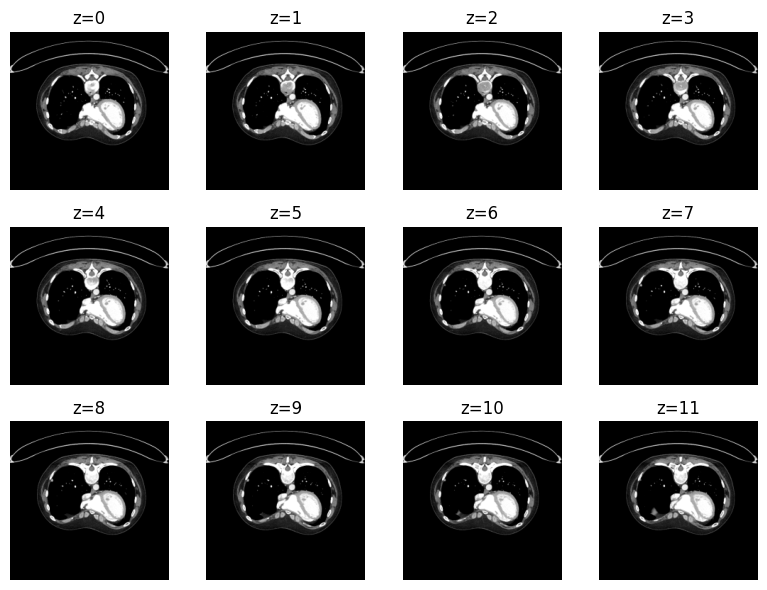

Saved figures\example_control_grid.png


In [8]:
def save_grid_for_patient(idx_df, pid, outpath, n=12):
    rows = idx_df[idx_df.patient_id == pid].sort_values('slice_idx').head(n)
    if rows.empty:
        print("No rows for", pid); return
    fig, axs = plt.subplots(3,4, figsize=(8,6))
    for ax, (_, r) in zip(axs.ravel(), rows.iterrows()):
        with Image.open(r['path']) as im:
            ax.imshow(im, cmap='gray')
        ax.set_title(f"z={int(r['slice_idx'])}")
        ax.axis('off')
    plt.tight_layout()
    plt.savefig(outpath, dpi=150, bbox_inches="tight")
    plt.show()
    print("Saved", outpath)

pid_cancer  = idx_clean[idx_clean.label=='cancer'].patient_id.iloc[0]
pid_control = idx_clean[idx_clean.label=='control'].patient_id.iloc[0]

save_grid_for_patient(idx_clean, pid_cancer,  FIG_DIR / "example_cancer_grid.png")
save_grid_for_patient(idx_clean, pid_control, FIG_DIR / "example_control_grid.png")

In [9]:
def compare_counts(df_a, df_b, name_a="full", name_b="clean"):
    print(f"{name_a} slices:", len(df_a), "|", name_b, "slices:", len(df_b))
    print("\nLabel counts:")
    print(pd.DataFrame({name_a: df_a['label'].value_counts(),
                        name_b: df_b['label'].value_counts()}).fillna(0).astype(int))
    print("\nPatients per class:")
    print(pd.DataFrame({
        name_a: df_a.groupby('label')['patient_id'].nunique(),
        name_b: df_b.groupby('label')['patient_id'].nunique()
    }))
compare_counts(idx_full, idx_clean)

full slices: 24627 | clean slices: 23319

Label counts:
          full  clean
control  18942  17749
cancer    5685   5570

Patients per class:
         full  clean
label               
cancer     40     40
control    80     80


In [10]:
import json
from datetime import datetime
from pathlib import Path

summary = {
    "timestamp": datetime.now().isoformat(timespec='seconds'),
    "full": {
        "n_slices": int(len(idx_full)),
        "label_counts": idx_full['label'].value_counts().to_dict(),
        "patients_per_class": idx_full.groupby('label')['patient_id'].nunique().to_dict(),
    },
    "clean": {
        "n_slices": int(len(idx_clean)),
        "label_counts": idx_clean['label'].value_counts().to_dict(),
        "patients_per_class": idx_clean.groupby('label')['patient_id'].nunique().to_dict(),
        "unique_modes_sizes": [ {"mode": m, "size": s} for (m, s) in shapes ],
    },
    "drops": {
        "count": int(pd.read_csv(DROP_LOG).shape[0]) if DROP_LOG.exists() else 0
    },
    "figures": {
        "cancer_grid":  str(FIG_DIR / "example_cancer_grid.png"),
        "control_grid": str(FIG_DIR / "example_control_grid.png")
    }
}

Path("reports").mkdir(parents=True, exist_ok=True)
with open("reports/ct_preprocessing_summary.json", "w") as f:
    json.dump(summary, f, indent=2)
print("Wrote reports/ct_preprocessing_summary.json")

Wrote reports/ct_preprocessing_summary.json


## Conclusion (CT preprocessing QC – Clean Index)

- Using `ct_index_clean.csv` (filtered tiny/blank slices).
- Consistent image mode/size across clean set.
- Patient counts preserved; per-slice noise reduced.
- Example grids saved to `figures/example_cancer_grid.png` and `figures/example_control_grid.png`.

Dataset ready for training; point dataloaders to **`ct_index_clean.csv`**.